# ECE420 iCard Scanner

In [41]:
# Import libraries
import cv2
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

In [49]:
# Function that returns the contour of the largest rectangular object in the frame
def get_bounding_quadrangle(img):
    kernel = np.ones((3,3), np.uint8)
    img_dilate = cv2.dilate(img, kernel, iterations=1)
    # cv2.imshow("Dilate", img_dilate)
    
    # Perform Canny Edge detection
    img_edgedetect = cv2.Canny(img_dilate, threshold1=100, threshold2=200)
#     cv2.imshow('Edges', img_edgedetect)
    
    # Get Contours 
    img_contours, hierarchy = cv2.findContours(img_edgedetect, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img_with_contours = np.ones_like(img, dtype=np.uint8) * 255
    
    max_area = 0
    max_idx = -1
    
    for idx, contour in enumerate(img_contours):
        contour_convex_hull = cv2.convexHull(contour)
        convex_hull_area = cv2.contourArea(contour_convex_hull)
        # print(contour_convex_hull)
        
        if(max_area < convex_hull_area):
            max_idx = idx
            max_area = convex_hull_area
    
    if (max_idx >= 0):
        cv2.drawContours(img_with_contours, [img_contours[max_idx]], 0, (0,255,0), 2)
        # cv2.imshow('Contours no hull', img_with_contours)
        cv2.drawContours(img_with_contours, [cv2.convexHull(img_contours[max_idx])], 0, (0,255,0), 2)
#         cv2.imshow('Contours', img_with_contours)
    else:
        print("No max contour found")
        return -1
        
    # Apply polygon approximation
    for err in np.linspace(0.005, 0.09, 80):
        approx_contour = cv2.approxPolyDP(cv2.convexHull(img_contours[max_idx]), err * cv2.arcLength(img_contours[max_idx], True), True)
        # print(f"err: {err}, numpt: {approx_contour.shape}")
        if(approx_contour.shape[0] == 4):
            break
    
    return (approx_contour, cv2.convexHull(img_contours[max_idx]))

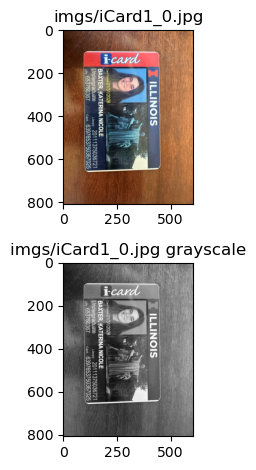

In [125]:
# Import 
IMG_DIR  = 'imgs/'
IMG_NAME = 'iCard1_0.jpg'

img_color = cv2.imread(f"{IMG_DIR}{IMG_NAME}")
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

plt.subplot(211)
plt.imshow(img_color[:,:,::-1])
plt.title(f"{IMG_DIR}{IMG_NAME}")
plt.subplot(212)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title(f"{IMG_DIR}{IMG_NAME} grayscale")
plt.tight_layout()

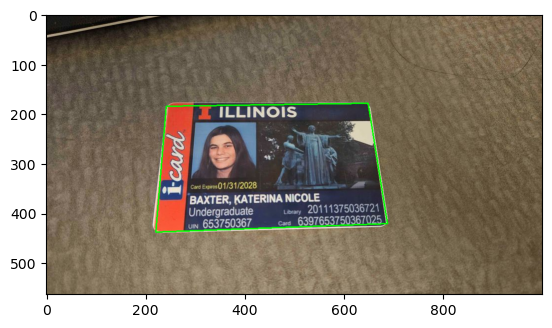

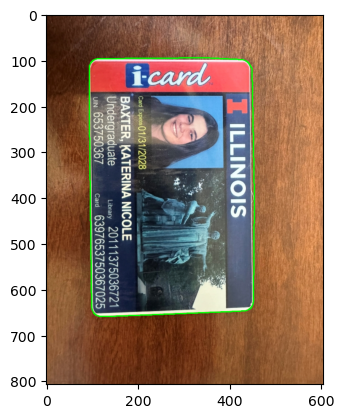

In [126]:
approx_contour, orig_contours = get_bounding_quadrangle(img)
img_poly_contour_approx = img_color.copy()
img_poly_contour_orig = img_color.copy()
cv2.drawContours(img_poly_contour_approx, [approx_contour], -1, (0,255,0), 2)
cv2.drawContours(img_poly_contour_orig, [orig_contours], -1, (0,255,0), 2)


plt.figure()
plt.imshow(img_poly_contour[:,:,::-1])
plt.figure()
plt.imshow(img_poly_contour_orig[:,:,::-1])

[[453 397]] -> [[448 119]]: 278.044960393099
[[347  95]] -> [[111  97]]: 236.00847442411893
[[451 625]] -> [[453 402]]: 223.00896842952304
[[ 94 222]] -> [[ 96 409]]: 187.0106948813356
[[ 96 409]] -> [[ 98 577]]: 168.01190434013895
[[ 94 113]] -> [[ 94 222]]: 109.0
[[218 656]] -> [[318 652]]: 100.07996802557443
[[427  99]] -> [[347  95]]: 80.09993757800315
[[139 659]] -> [[218 656]]: 79.05694150420949
[[318 652]] -> [[392 649]]: 74.06078584514209
[[453 397 448 119]
 [347  95 111  97]
 [451 625 453 402]
 [ 94 222  96 409]
 [ 96 409  98 577]
 [ 94 113  94 222]
 [218 656 318 652]
 [427  99 347  95]
 [139 659 218 656]
 [318 652 392 649]]
slope ratio[1]: 0.9998475795634678
slope ratio[2]: 1.0053956834532372
slope ratio[3]: 0.6816546762589928
Slope arr: [ 5.56000000e+01 -8.47457627e-03 -1.11500000e+02  9.35000000e+01]
yint arr: [-24789.8            97.94067797  50911.5         -8567.        ]
opp idx: 3
Corners: [[  447    63]
 [  453   397]
 [  290 18548]
 [   92    35]]


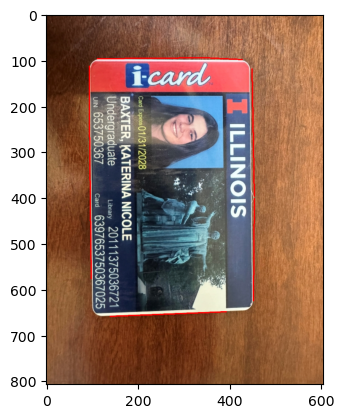

In [144]:
img_poly_contour_longest_lines = img_color.copy()

distances = orig_contours - np.roll(orig_contours, 1, axis=0)
distances = np.linalg.norm(distances, axis=2).flatten()

N_lines = 10
# 4 lines, each one is (x1,y1,x2,y2)
lines = np.zeros((N_lines,4), dtype=np.int32)

for i in range(N_lines):
    max_idx = np.argsort(distances)[-(i+1)]
    print(f"{orig_contours[max_idx]} -> {orig_contours[max_idx - 1]}: {distances[max_idx]}")
    lines[i][0:2] = orig_contours[max_idx][0]
    lines[i][2:4] = orig_contours[max_idx-1][0]
    
print(lines)

corners = np.zeros((4,2), dtype=np.int32)

# Find equations for each line
slope_array = np.zeros(4)
y_int_array = np.zeros(4)

for i in range(4):
    slope_array[i] = (lines[i][3]-lines[i][1]) / (lines[i][2]-lines[i][0])
    y_int_array[i] = lines[i][1] - slope_array[i] * lines[i][0]

# Find 1 pair of opposite sides (idx 0 and its opposite side)
if(np.abs(slope_array[0]) < 0.001):
    slope_array[0] = 0.001
    
opposite_idx = 1
slope_ratio = np.abs(np.abs(slope_array[1] / slope_array[0]) - 1)
print(F"slope ratio[1]: {slope_ratio}")

for i in range(2,4):
    new_slope_ratio = np.abs(np.abs(slope_array[i] / slope_array[0]) - 1)
    print(F"slope ratio[{i}]: {new_slope_ratio}")
    if(new_slope_ratio < slope_ratio):
        slope_ratio = new_slope_ratio
        opposite_idx = i
        
# Find 2 corners next to side 0
if(opposite_idx == 1):
    adj_idx = np.array((2,3))
elif(opposite_idx == 2):
    adj_idx = np.array((1,3))
else:
    adj_idx = np.array((1,2))

for i in range(2):
    corners[i][0] = (y_int_array[adj_idx[i]] - y_int_array[0]) / (slope_array[0] - slope_array[adj_idx[i]])
    corners[i][1] = slope_array[0] * corners[i][0] + y_int_array[0]
    corners[3-i][0] = (y_int_array[adj_idx[i]] - y_int_array[opposite_idx]) / (slope_array[opposite_idx] - slope_array[adj_idx[i]])
    corners[3-i][1] = slope_array[opposite_idx] * corners[3-i][0] + y_int_array[opposite_idx]

print(f"Slope arr: {slope_array}")
print(f"yint arr: {y_int_array}")
print(f"opp idx: {opposite_idx}")

    
for i in range(N_lines):
    cv2.line(img_poly_contour_longest_lines, lines[i][0:2], lines[i][2:4], (0, 0, 255), 2)
#     if(i == 0 or i == opposite_idx):
#         cv2.line(img_poly_contour_longest_lines, lines[i][0:2], lines[i][2:4], (0, 0, 255), 5)
#     cv2.line(img_poly_contour_longest_lines, corners[i], corners[i-1], (0, 255, 0), 2)
    
print(f"Corners: {corners}")

plt.imshow(img_poly_contour_longest_lines[:,:,::-1])